# Monte-Carlo policy gradient

In [1]:
import torch
from torch import nn

import numpy as np
import gym

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import gc
import time
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
import random

from sklearn.preprocessing import StandardScaler

SEED = 33
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

'''
Класс для policy сети, можно создать с произвольным числом слоев и нейронов
Возвращает параметры нормального распределения, из которого сэмплится действие агента
'''

class PolicyNet(nn.Module):
    
    def __init__(self, structure):
        super().__init__()
        self.arch = nn.ModuleList()
        for i in range(len(structure) - 1):
            self.arch.add_module(f'linear{i}', nn.Linear(structure[i], structure[i+1]))
            if i != (len(structure) - 2):
                self.arch.add_module(f'relu{i}', nn.ReLU())
        self.mu = nn.Sequential(nn.Linear(structure[-1], 1),
                                nn.Tanh())
        self.sigma = nn.Sequential(nn.Linear(structure[-1], 1),
                                   nn.Softplus())
            
    def forward(self, x):
        for layer in self.arch:
            x = layer(x)
        return self.mu(x), self.sigma(x)

def mod_reward(reward, state, new_state, unseen, unseen_prev): 
    '''
    Функция модификации награды, принимает еще аргументы unseen, видел ли
    агент ранее это состояние. Использовал раньше в функции модификации, но
    сейчас отказался. Оставил аргументами, чтобы можно было еще поэксперементировать.
    '''
    addition = GAMMA * (abs(new_state[0, 1])) -\
                        (abs(state[0, 1]))
    return reward + REW_MULT * addition
    
class Agent:
    
    def __init__(self, structure):
        self.policy = PolicyNet(structure)
        self.opt = torch.optim.Adam(self.policy.parameters(), ALPHA)
        
        decay_func = lambda epoch: (N_EPOCHS - epoch)/N_EPOCHS
        self.scheduler = torch.optim.lr_scheduler.LambdaLR(self.opt, decay_func)
        
        self.scaler = StandardScaler()
        sample = np.vstack([ENV.observation_space.sample() for i in range(int(1e5))])
        self.scaler.fit(sample)
        
    def act(self, state):
        '''
        Пропускаем состояние через Policy сеть, получаем параметры нормального распределения
        Сэмплим действие и считаем логарифм вероятности данного действия
        '''
        state = torch.tensor(state).type('torch.FloatTensor')
        mu, sigma2 = self.policy(state)
        with torch.no_grad():
            std = torch.sqrt(sigma2)
            action = torch.normal(mean=mu,
                                  std=std)
        log_prob = - ((mu - action) ** 2)/(2 * sigma2)
        log_prob += - torch.log(torch.sqrt(2 * np.pi * sigma2))
        action = torch.clamp(action,
                             ENV.action_space.low[0],
                             ENV.action_space.high[0]).numpy()
        return action, log_prob
    
    def train(self, n_epochs):
        self.total_rewards = []
        self.total_rewards_ = []
        self.fpos = []
        max_pos = np.NINF
        min_pos = np.Inf
        for i in tqdm_notebook(range(n_epochs)):
            
            if (i%100 == 0):
                mean_rew = round(np.mean(self.total_rewards[i-100:i]), 3)
                mean_rew_ = round(np.mean(self.total_rewards_[i-100:i]), 3)
                pmax_pos = self.scaler.inverse_transform(np.array([[max_pos, 0]]))[0, 0]
                print(f'Iteration {i}', 
                      f'Mean reward = {mean_rew}', 
                      f'max_pos = {pmax_pos}, mean_mod_rew = {mean_rew_}')
                torch.save(self.policy.state_dict(),SAVEPATH+f'{mean_rew}_{i//100}')
                
                
            state = ENV.reset()
            state = self.scaler.transform(state.reshape(1, -1))
            running_rew = 0
            running_rew_ = 0
            rewards = []
            log_probas = []
            unseen_prev = False
            for j in range(STEPS):
                
                action, log_proba = self.act(state)
                new_state, reward, done, info = ENV.step(action)
                new_state = self.scaler.transform(new_state.reshape(1, -1))
                
                unseen = False
                if new_state[0, 0] > max_pos:
                    max_pos = new_state[0, 0]
                    unseen = True
                    
                elif new_state[0, 0] < min_pos:
                    min_pos = new_state[0, 0]
                    unseen = True
                    
                running_rew += reward
                reward = mod_reward(reward, state, new_state, unseen, unseen_prev)
                running_rew_ += reward
                state = new_state
                rewards.append(reward)
                log_probas.append(log_proba)
                unseen_prev = unseen
                
                if done:
                    break
            self.learn_from_episode(rewards[:j+1], log_probas[:j+1]) 
            self.scheduler.step()
            self.total_rewards.append(running_rew)
            self.total_rewards_.append(running_rew_)
        
    def learn_from_episode(self, rewards, log_probas):
        '''
        Считаем returns из наград, собранных за эпизод
        Получаем loss для policy сети, обновляем веса
        '''
        from itertools import accumulate
        returns = list(accumulate(reversed(rewards), lambda x, y: GAMMA * x + y))[::-1]
        returns = torch.tensor(returns).type('torch.FloatTensor')
        self.opt.zero_grad()
        loss_val = - (torch.squeeze(torch.stack(log_probas)) * returns).sum()
        loss_val.backward()
        self.opt.step()
        
    def test(self, N, plot=False):
        
        rewards = np.zeros(N)
        fpos = np.zeros(N)
        n_steps = np.zeros(N)
        successes = 0
        
        for i in tqdm_notebook(range(N)):
            state = ENV.reset()
            running_reward = 0
            for j in range(STEPS):
                state = agent.scaler.transform(state.reshape(1, -1))
                action, _ = agent.act(state)
                ns, rew, done, _ = ENV.step(action)
                running_reward += rew
                state = ns
                if done:
                    successes += 1
                    break
            rewards[i] = running_reward
            fpos[i] = state[0]
            n_steps[i] = j
        
        if plot:
            fig, axarr = plt.subplots(1, 3, figsize=[20, 10])
            fig.suptitle(f'Performance test over {N} iterations')

            axarr[0].hist(rewards, label=f'Mean reward = {round(np.mean(rewards), 3)}')
            axarr[0].set_title('Rewards per episode')

            axarr[1].hist(fpos, 
                          label = f'Successful episodes = {round(successes/N * 100, 3)} %')
            axarr[1].set_title('Positions at the end of an episode')

            axarr[2].hist(n_steps[fpos >= 0.5], 
                          label = f'Mean = {round(np.mean(n_steps[fpos>=0.5]), 3)}')
            axarr[2].set_title('Number of iterations it took \n to succeed')

            for ax in axarr:
                ax.legend()
                ax.grid()
        
        return rewards, fpos, n_steps

In [2]:
#Поменял с REINFORCE2 на REINFORCE3, чтобы случайно все не перезаписалось
SAVEPATH = 'cont_models/REINFORCE3/RFMCcont_' 

In [3]:
ENV = gym.make('MountainCarContinuous-v0')
ENV.seed(SEED)
ENV.reset()

array([-0.57840555,  0.        ])

In [4]:
#Гиперпараметры
GAMMA = 0.99
REW_MULT = 600
ALPHA = 5e-4
N_EPOCHS = int(7e3)
STEPS = 200

In [5]:
agent = Agent([ENV.observation_space.shape[0],
              128,
              64])

Тренируем агента, сходимости очень помогли низкий lr и линейное уменьшенение lr с каждой итерацией.

In [6]:
agent.train(N_EPOCHS)

/home/dmitry/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dmitry/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Iteration 0 Mean reward = nan max_pos = -inf, mean_mod_rew = nan
Iteration 100 Mean reward = -8.466 max_pos = 0.4702107220693058, mean_mod_rew = -54.84
Iteration 200 Mean reward = 14.299 max_pos = 0.4876350878631862, mean_mod_rew = -26.284


/home/dmitry/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Iteration 300 Mean reward = 78.908 max_pos = 0.5014097809595275, mean_mod_rew = 173.342
Iteration 400 Mean reward = 89.322 max_pos = 0.5084184093583898, mean_mod_rew = 315.486
Iteration 500 Mean reward = 91.973 max_pos = 0.5084184093583898, mean_mod_rew = 338.51
Iteration 600 Mean reward = 90.444 max_pos = 0.5084184093583898, mean_mod_rew = 372.315
Iteration 700 Mean reward = 92.312 max_pos = 0.5102477387752101, mean_mod_rew = 446.515
Iteration 800 Mean reward = 92.069 max_pos = 0.5106857664301354, mean_mod_rew = 430.604
Iteration 900 Mean reward = 91.905 max_pos = 0.5106857664301354, mean_mod_rew = 251.767
Iteration 1000 Mean reward = 92.538 max_pos = 0.5106857664301354, mean_mod_rew = 440.798
Iteration 1100 Mean reward = 92.293 max_pos = 0.5106857664301354, mean_mod_rew = 478.605
Iteration 1200 Mean reward = 92.12 max_pos = 0.5106857664301354, mean_mod_rew = 427.22
Iteration 1300 Mean reward = 91.553 max_pos = 0.5106857664301354, mean_mod_rew = 275.035
Iteration 1400 Mean reward = 92

Выберем сеть с лучшей средней наградой за сто итераций обучения:

In [7]:
sdict = torch.load('cont_models/REINFORCE2/RFMCcont_93.776_45')
agent.policy.load_state_dict(sdict)

/home/dmitry/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


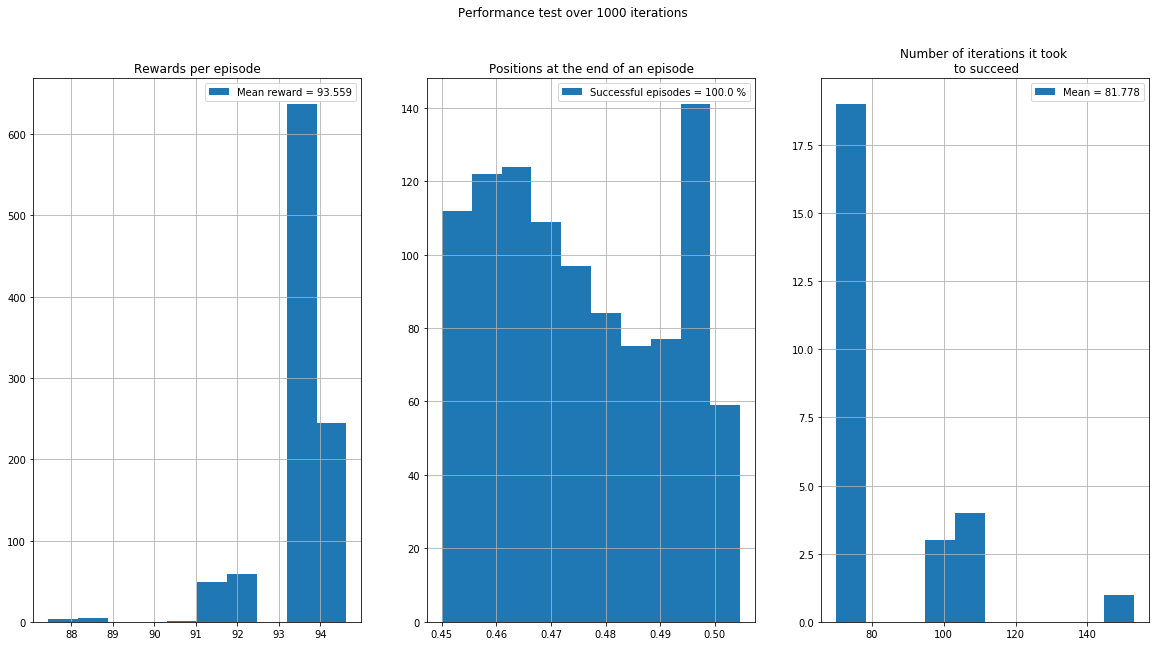

In [8]:
_ = agent.test(1000, True)

Сравним с последней сохраненной сетью:

In [9]:
sdict = torch.load('cont_models/REINFORCE2/RFMCcont_93.444_69')
agent.policy.load_state_dict(sdict)

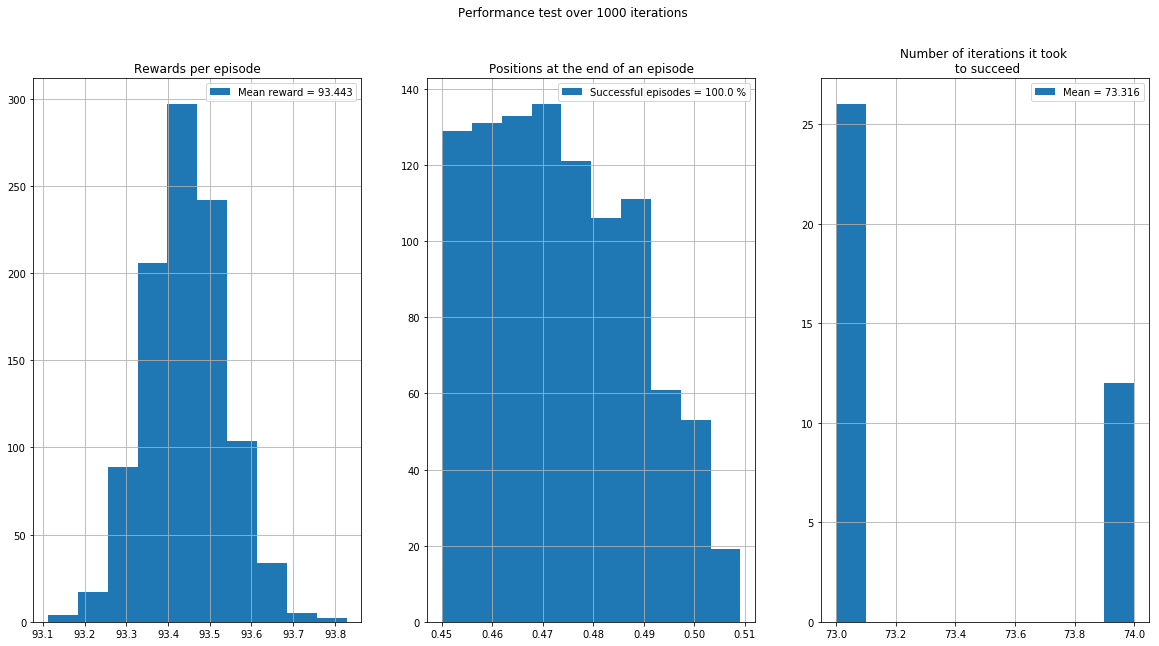

In [10]:
_ = agent.test(1000, True)

Сеть научилась справляться с задачей быстрее, у награды стала меньше дисперсия, но среднее

Можно визуализировать:

In [25]:
state = ENV.reset()
tot_rew = 0
for i in range(200):
    state = agent.scaler.transform(state.reshape(1, -1))
    act, _ = agent.act(state)
    state, rew, done, _ = ENV.step(act)
    ENV.render()    
    time.sleep(0.1)
    tot_rew += rew
    if done:
        break
ENV.close()
print(tot_rew)

92.58216127216731
